<a href="https://colab.research.google.com/github/aymen5507/aymen5507/blob/main/causal_bandito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [ ]:
k = 10
num_problems = 2000

q_star = np.random.normal(0, 1, (num_problems,k))
arms = [0] * k

for i in range(10):
    arms[i] = np.random.normal(q_star[0, i], 1, 2000) # first problem as a sample

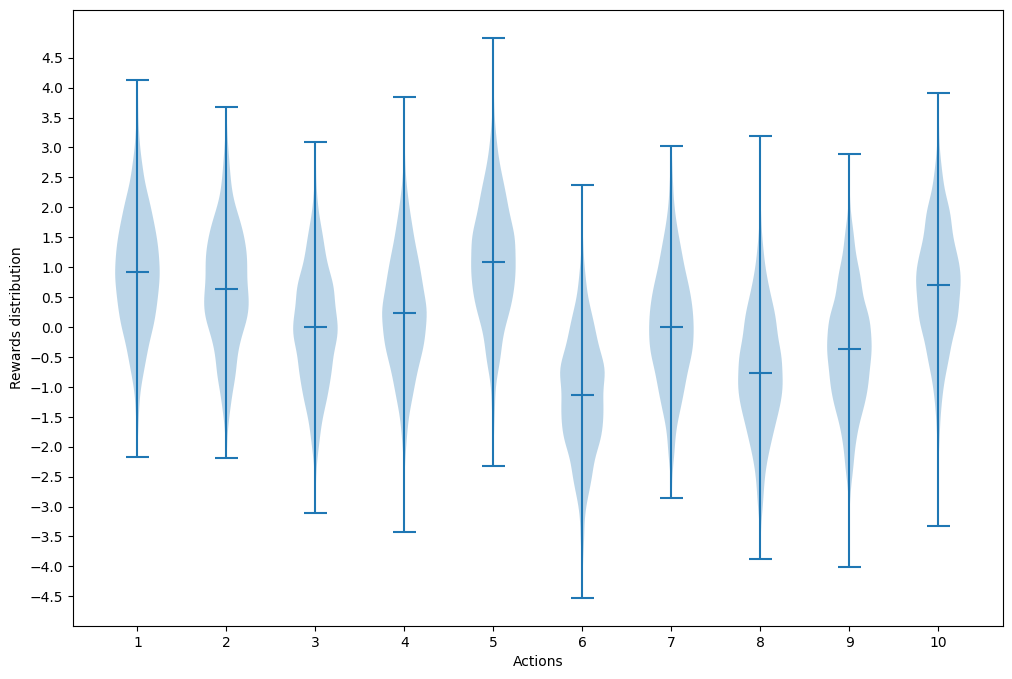

In [ ]:
plt.figure(figsize=(12,8))
plt.ylabel('Rewards distribution')
plt.xlabel('Actions')
plt.xticks(range(1,11))
plt.yticks(np.arange(-5,5,0.5))

plt.violinplot(arms, positions=range(1,11), showmedians=True)
plt.show()

In [ ]:
from scipy import stats
from sklearn.linear_model import LinearRegression

##
plt.style.use('fivethirtyeight')
##



In [ ]:
## define SCM

class GPSMemorySCM:
  def __init__(self, random_seed=None) :
    self.random_seed = random_seed
    self.u_x = stats.truncnorm(0,np.infty, scale=5)
    self.u_y = stats.norm(scale=2)
    self.u_z = stats.norm(scale=2)
    self.u = stats.truncnorm(0, np.infty, scale=4)
  def sample(self, sample_size=100 , treatment_value=None):
    if self.random_seed:
      np.random.seed(self.random_seed)
    u_x= self.u_x.rvs(sample_size)
    u_y= self.u_y.rvs(sample_size)
    u_z= self.u_z.rvs(sample_size)
    u= self.u.rvs(sample_size)
    if treatment_value:
      gps= np.array([treatment_value]*sample_size)
    else:
      gps = u_x + 0.7*u
    hippocamus = -0.6*gps + 0.25*u_z
    memory = -0.6*hippocamus + 0.25*u_z

    return gps, hippocamus, memory

  def intervene(self, treatment_value, sample_size=100):
    return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [ ]:
 ## int and generation of obs
 scm = GPSMemorySCM()
 gps_obs, hippocampus_obs, memory_obs = scm.sample(600)

In [ ]:
treatments= []
experiment_results = []

#sample over a range of treatments

for treatment in np.arange(1, 21):
  gps_hours, hippocampus, memory = scm.intervene(treatment_value=treatment, sample_size=30)
  experiment_results.append(memory)
  treatments.append(gps_hours)

In [ ]:
### lets fit regression models

lr_naive = LinearRegression()
lr_naive.fit(
    X=gps_obs.reshape(-1, 1),
    y=memory_obs
)

LinearRegression()

In [ ]:
treatments_unpack = np.array(treatments).flatten()
results_unpack = np.array(experiment_results).flatten()

lr_experiment = LinearRegression()
lr_experiment.fit(
    X=treatments_unpack.reshape(-1, 1),
    y=results_unpack
)

LinearRegression()

In [ ]:
X_test = np.arange(1, 21).reshape(-1, 1)
preds_naive = lr_naive.predict(X_test)
preds_experiment= lr_experiment.predict(X_test)

In [ ]:
print(f'Naive model:\n{lr_naive.coef_}\n')

print(f'Experimental model:\n{lr_experiment.coef_}\n')


Naive model:
[0.35903406]

Experimental model:
[0.36025271]



In [ ]:
!pip install git+https://github.com/py-why/dowhy@main

  Cloning https://github.com/py-why/dowhy (to revision main) to /tmp/pip-req-build-s_kewx7b
  Running command git clone --filter=blob:none --quiet https://github.com/py-why/dowhy /tmp/pip-req-build-s_kewx7b
  Resolved https://github.com/py-why/dowhy to commit 0fa9a2e15cacb43af6f8643cb36c70ab69aba431
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 1.6 MB/s eta 0:00:00
  Created wheel for dowhy: filename=dowhy-0.0.0-py3-none-any.whl size=393118 sha256=41bf94a24f703411ed53cceeba14e5bcbf3dc22d22c329a094c3dba73ca23ecf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ub1ry30t/wheels/81/1f/8f/e4c723aeb18297310035f1f6c16475ee705c060e0dd48e7209
Successfully built dowhy


In [ ]:
from dowhy import CausalModel
import dowhy.datasets

# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True)

In [ ]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])  # Or alternatively, as nx.DiGraph

# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect()

# III. Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")

# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")

In [ ]:
data

{'df':        Z0        Z1        W0        W1        W2        W3        W4    v0  \
 0     1.0  0.758266 -2.793265 -1.006424 -0.386331  0.037085  1.125787  True   
 1     1.0  0.764214 -1.102673 -0.052479  0.890409 -0.094897 -0.675604  True   
 2     1.0  0.731267 -0.782834 -0.885446  0.114616 -0.666765  0.630301  True   
 3     1.0  0.459946 -1.040372 -1.315806 -1.059991  0.906243  0.339799  True   
 4     1.0  0.362875 -0.542327 -1.066510  1.334443  0.582120  1.160283  True   
 ...   ...       ...       ...       ...       ...       ...       ...   ...   
 9995  1.0  0.643710  0.084445 -0.256091  1.373429 -1.044787  1.692702  True   
 9996  1.0  0.796854 -0.179834 -0.335685  1.078343 -1.692533  0.903340  True   
 9997  1.0  0.954350  1.723219 -0.481983  1.428416  0.041148  0.138094  True   
 9998  1.0  0.245690  1.188603  0.887122 -0.065917  0.549452  2.131881  True   
 9999  1.0  0.668549  0.253398 -0.837803  0.868734 -0.660559  0.219929  True   
 
               y  propensity_sco

Test permutations of given graph: 100%|██████████| 6/6 [00:00<00:00, 11.12it/s]


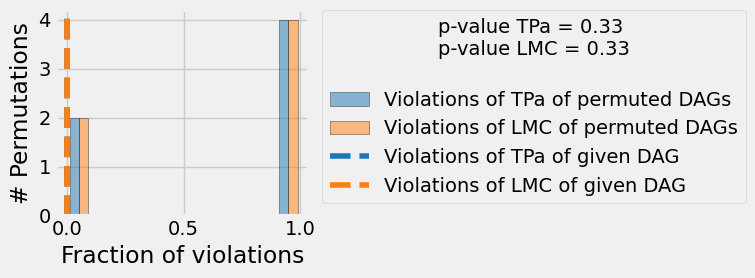

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

Evaluate set function: 8it [00:00, 80.56it/s]


In [ ]:
import networkx as nx, numpy as np, pandas as pd
from dowhy import gcm

# Let's generate some "normal" data we assume we're given from our problem domain:
X = np.random.normal(loc=0, scale=1, size=1000)
Y = 2 * X + np.random.normal(loc=0, scale=1, size=1000)
Z = 3 * Y + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(dict(X=X, Y=Y, Z=Z))

# 1. Modeling cause-effect relationships as a structural causal model
#    (causal graph + functional causal models):
causal_model = gcm.StructuralCausalModel(nx.DiGraph([('X', 'Y'), ('Y', 'Z')]))  # X -> Y -> Z
gcm.auto.assign_causal_mechanisms(causal_model, data)

# 2. Fitting the SCM to the data:
gcm.fit(causal_model, data)

# Optional: Evaluate causal model
print(gcm.evaluate_causal_model(causal_model, data))

# Step 3: Perform a causal analysis.
# results = gcm.<causal_query>(causal_model, ...)
# For instance, root cause analysis:
anomalous_sample = pd.DataFrame(dict(X=[0.1], Y=[6.2], Z=[19]))  # Here, Y is the root cause.

# "Which node is the root cause of the anomaly in Z?":
anomaly_attribution = gcm.attribute_anomalies(causal_model, "Z", anomalous_sample)

# Or sampling from an interventional distribution. Here, under the intervention do(Y := 2).
samples = gcm.interventional_samples(causal_model, interventions={'Y': lambda y: 2}, num_samples_to_draw=100)

In [ ]:
!pip install pgmpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import networkx as nx

from pgmpy.models import BayesianNetwork as bn
from pgmpy.inference import BeliefPropagation, VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.factors.discrete.DiscreteFactor import DiscreteFactor

import pylab as plt

In [ ]:
def do(model, interventions):
    """
    Implement an ideal intervention for discrete variables. Modifies pgmpy's
    `do` method so it is a `do`-operator, meaning a function that takes in a
    model, modifies it with an ideal intervention, and returns a new model.
    Note that this code would need to be modified to work for continuous
    variables.
    """
    def _mod_kernel(kernel, int_val):
        """
        Modify a causal Markov kernel so all probability is on the state fixed
        by the intervention.
        """
        var_name = kernel.variable
        card = kernel.get_cardinality([var_name])[var_name]
        states = [kernel.get_state_names(var_name, i) for i in range(card)]
        non_int_states = set(states) - {int_val,}
        unordered_prob_vals = [[1.0]] + [[0.0] for _ in range(card - 1)]
        unordered_states = [int_val] + list(non_int_states)
        # Reorder so it matches original
        dict_ = dict(zip(unordered_states, unordered_prob_vals))
        ordered_prob_values = [dict_[k] for k in states]
        intervention_kernel = TabularCPD(
            var_name, card, ordered_prob_values,
            state_names = {var_name: states}
        )
        return intervention_kernel

    kernels = {kern.variable: kern for kern in model.get_cpds()}
    new_model = model.copy()
    for var, int_val in interventions.items():
        new_model = new_model.do(var)
        new_kernel = _mod_kernel(kernels[var], int_val)
        new_model.add_cpds(new_kernel)
    return new_model

def weighted_mean(vals, weights):
    """
    Calculate a weighted mean
    """
    assert len(vals) == len(weights)
    norm = sum(weights)
    probs = [w/norm for w in weights]
    mean = sum(val * p for val, p in zip(vals, probs))
    return mean

def get_expected_utility(inference_result: DiscreteFactor, u_node: str="U"):
    """
    Calculate expected utility from the output of an inference algorithm
    """
    utilities = inference_result.state_names[u_node]
    probs = inference_result.values
    return weighted_mean(utilities, probs)
def get_expected_utility_given_evidence(model, evidence, u_node="U",
                                        inference_engine=VariableElimination):
    """
    Calculate expected utility from the output of an inference algorithm
    """
    engine = inference_engine(model)
    inference_result = engine.query([u_node], evidence=evidence)
    expected_u = get_expected_utility(inference_result, u_node)
    return expected_u

def get_expected_utility_given_interventions(model, interventions, u_node="U",
                                            inference_engine=VariableElimination):
    int_model = do(model, interventions)
    expected_u = get_expected_utility_given_evidence(
        int_model,
        evidence=interventions,
        u_node=u_node,
        inference_engine=inference_engine
    )
    return expected_u


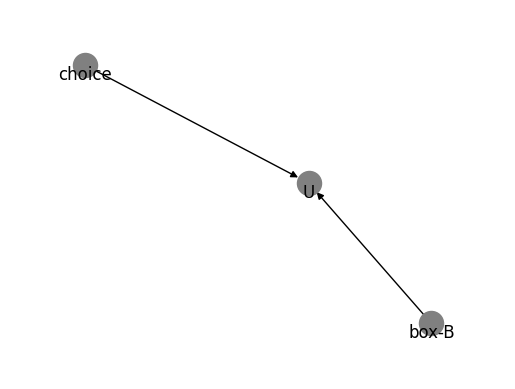

In [ ]:
model = bn()
model.add_edges_from(
    [
      ('choice','U'),
      ('box-B','U'),
    ]
)
ax1 = plt.subplot(111)
ax1.margins(0.15)
pos = nx.nx_pydot.graphviz_layout(model)
nx.draw(model, pos, ax=ax1, with_labels=True, node_color='grey', verticalalignment='top')
plt.show()

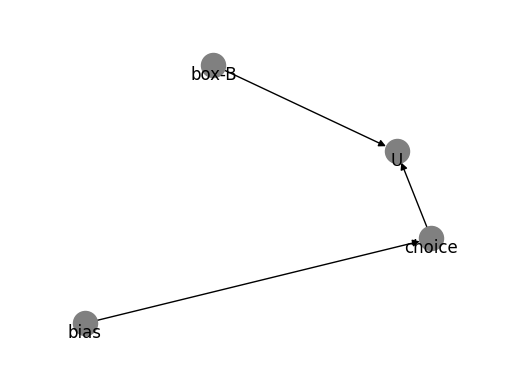

In [ ]:
model = bn()
model.add_edges_from(
    [
      ('bias','choice'),
      ('choice','U'),
      ('box-B','U'),
    ]
)
ax1 = plt.subplot(111)
ax1.margins(0.15)
pos = nx.nx_pydot.graphviz_layout(model)
nx.draw(model, pos, ax=ax1, with_labels=True, node_color='grey', verticalalignment='top')
plt.show()

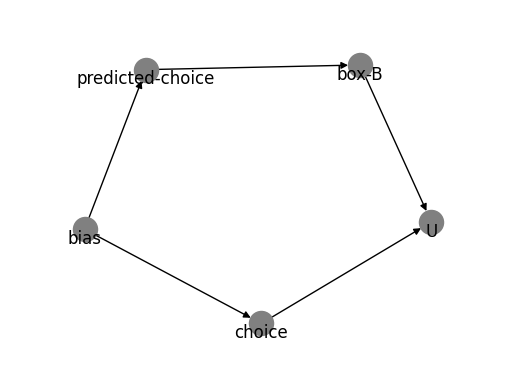

In [ ]:
model = bn()
model.add_edges_from(
    [
      ('bias','predicted-choice'),
      ('bias','choice'),
      ('predicted-choice','box-B'),
      ('choice','U'),
      ('box-B','U'),
    ]
)
ax1 = plt.subplot(111)
ax1.margins(0.15)
pos = nx.nx_pydot.graphviz_layout(model)
nx.draw(model, pos, ax=ax1, with_labels=True, node_color='grey', verticalalignment='top')
plt.show()


In [ ]:
# Building the model

In [ ]:
kernel_bias = TabularCPD(
    'bias', 2, [[.5], [.5]],
    state_names= {'bias': ['B', 'both']}
)
print(kernel_bias)

+------------+-----+
| bias(B)    | 0.5 |
+------------+-----+
| bias(both) | 0.5 |
+------------+-----+


In [ ]:
kernel_choice = TabularCPD('choice', 2, [[1, 0], [0, 1]],
                      evidence=['bias'], evidence_card=[2],
                      state_names = {
                          'choice': ['B', 'both'],
                          'bias': ['B', 'both']
                      })
print(kernel_choice)

+--------------+---------+------------+
| bias         | bias(B) | bias(both) |
+--------------+---------+------------+
| choice(B)    | 1.0     | 0.0        |
+--------------+---------+------------+
| choice(both) | 0.0     | 1.0        |
+--------------+---------+------------+


In [ ]:
kernel_prediction = TabularCPD('predicted-choice', 2, [[.95, 0.05], [.05, .95]],
                      evidence=['bias'], evidence_card=[2],
                      state_names = {
                          'predicted-choice': ['B', 'both'],
                          'bias': ['B', 'both']
                      })
print(kernel_prediction)


+------------------------+---------+------------+
| bias                   | bias(B) | bias(both) |
+------------------------+---------+------------+
| predicted-choice(B)    | 0.95    | 0.05       |
+------------------------+---------+------------+
| predicted-choice(both) | 0.05    | 0.95       |
+------------------------+---------+------------+


In [ ]:
kernel_box_b = TabularCPD('box-B', 2, [[0, 1], [1, 0]],
                      evidence=['predicted-choice'], evidence_card=[2],
                      state_names = {
                          'box-B': [0, 1000000],
                          'predicted-choice': ['B', 'both']
                      })
print(kernel_box_b)


+------------------+---------------------+------------------------+
| predicted-choice | predicted-choice(B) | predicted-choice(both) |
+------------------+---------------------+------------------------+
| box-B(0)         | 0.0                 | 1.0                    |
+------------------+---------------------+------------------------+
| box-B(1000000)   | 1.0                 | 0.0                    |
+------------------+---------------------+------------------------+


In [ ]:
kernel_u = TabularCPD('U', 4,
                        [
                            [1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1],
                        ],
                        evidence=['box-B','choice'], evidence_card=[2, 2],
                        state_names = {
                            'U': [0, 1000, 1000000, 1001000],
                            'box-B': [0, 1000000],
                            'choice': ['B', 'both']
                        }
                      )
print(kernel_u)


+------------+-----------+--------------+----------------+----------------+
| box-B      | box-B(0)  | box-B(0)     | box-B(1000000) | box-B(1000000) |
+------------+-----------+--------------+----------------+----------------+
| choice     | choice(B) | choice(both) | choice(B)      | choice(both)   |
+------------+-----------+--------------+----------------+----------------+
| U(0)       | 1.0       | 0.0          | 0.0            | 0.0            |
+------------+-----------+--------------+----------------+----------------+
| U(1000)    | 0.0       | 1.0          | 0.0            | 0.0            |
+------------+-----------+--------------+----------------+----------------+
| U(1000000) | 0.0       | 0.0          | 1.0            | 0.0            |
+------------+-----------+--------------+----------------+----------------+
| U(1001000) | 0.0       | 0.0          | 0.0            | 1.0            |
+------------+-----------+--------------+----------------+----------------+


In [ ]:
model.add_cpds(kernel_bias, kernel_prediction, kernel_box_b, kernel_choice, kernel_u)


In [ ]:
u_given_b = get_expected_utility_given_evidence(model, evidence = {'choice': 'B'})
u_given_both = get_expected_utility_given_evidence(model, evidence = {'choice': 'both'})
print("E(U|choice=B) = " + str(u_given_b) + "\n")
print("E(U|choice=both) = " + str(u_given_both) + "\n")


E(U|choice=B) = 950000.0

E(U|choice=both) = 51000.0



In [ ]:
u_given_do_b = get_expected_utility_given_interventions(model, interventions = {'choice': 'B'})
u_given_do_both = get_expected_utility_given_interventions(model, interventions = {'choice': 'both'})
print("E(U|do(choice=B)) = " + str(u_given_do_b) + "\n")
print("E(U|do(choice=both)) = " + str(u_given_do_both) + "\n")


E(U|do(choice=B)) = 500000.0

E(U|do(choice=both)) = 501000.0



In [ ]:
## resolving the paradox

In [ ]:
def dict_argmax(d: dict):
    """Returns key with greatest value"""
    return max(d, key=lambda k: d[k])


In [ ]:
# max(d) returns the largest key, NOT the key with the largest value
d = {"B":100, "both":1000}
print(dict_argmax(d), max(d))

d = {"B":1000, "both":100}
print(dict_argmax(d), max(d))


both both
B both


In [ ]:
def decide_for_agent(model, bias):
    utilities = {}
    for intervention in ['both', 'B']:
        int_model = do(model, {'choice': intervention})
        expected_u = get_expected_utility_given_evidence(
            int_model,
            evidence= {
                'bias': bias
            },
        )
        utilities[intervention] = expected_u
    return utilities


decision_d = dict()
for bias in ["B", "both"]:
    decision_d[bias] = decide_for_agent(model, bias=bias)

for bias, decision in decision_d.items():

    print(f"Dear agent, you are biased towards {bias}.")
    decision_max = dict_argmax(decision)
    print(f"You should choose " + str(decision_max) + ".")
    print(decision)
    print("")


Dear agent, you are biased towards B.
You should choose both.
{'both': 951000.0, 'B': 950000.0}

Dear agent, you are biased towards both.
You should choose both.
{'both': 51000.0, 'B': 50000.0}

